In [1]:
# --- Step 1: Imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Activation, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time

# --- Step 2: Load and Preprocess Dataset ---
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)

train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train_cat, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val_cat, batch_size=32)
test_generator = test_datagen.flow(x_test, y_test_cat, batch_size=32, shuffle=False)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# --- Step 3: Build Teacher Model (VGG16-based) ---
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
logits = Dense(10)(x)
output = Activation('softmax')(logits)

teacher = Model(base_model.input, output)
teacher.compile(Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.summary()

# --- Step 4: Train Teacher ---
history_teacher = teacher.fit(train_generator, validation_data=val_generator, epochs=10)

# --- Step 5: Define Teacher Extractors ---
teacher_feature = Model(teacher.input, base_model.get_layer('block3_pool').output)
teacher_logits_m = Model(teacher.input, logits)

# --- Step 6: Build Student Model (Simple CNN) ---
input_s = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_s)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
hint = BatchNormalization(name='hint_layer')(x)  # 4x4x128
x = Flatten()(hint)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
logits_s = Dense(10)(x)
output_s = Activation('softmax')(logits_s)

student = Model(input_s, output_s)

# --- Step 7: Define Student Extractors ---
student_feature = Model(student.input, student.get_layer('hint_layer').output)
student_logits_m = Model(student.input, logits_s)

# --- Step 8: Define Distillation Model ---
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher, teacher_feature, student_feature, teacher_logits, student_logits, alpha=0.5, temperature=5, gamma=0.5):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.teacher_feature = teacher_feature
        self.student_feature = student_feature
        self.teacher_logits = teacher_logits
        self.student_logits = student_logits
        self.alpha = alpha
        self.temperature = temperature
        self.gamma = gamma
        self.feature_adapter = Conv2D(256, (1, 1))  # Adapt 128 to 256 channels

    def compile(self, optimizer, metrics, distillation_loss_fn, student_loss_fn):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.distillation_loss_fn = distillation_loss_fn
        self.student_loss_fn = student_loss_fn

    def train_step(self, data):
        x, y = data
        teacher_logits = self.teacher_logits(x, training=False)
        teacher_hint = self.teacher_feature(x, training=False)

        with tf.GradientTape() as tape:
            student_logits = self.student_logits(x, training=True)
            student_pred = tf.nn.softmax(student_logits)
            student_hint = self.student_feature(x, training=True)
            adapted_hint = self.feature_adapter(student_hint)

            student_loss = self.student_loss_fn(y, student_pred)

            soft_teacher = tf.nn.softmax(teacher_logits / self.temperature)
            soft_student = tf.nn.softmax(student_logits / self.temperature)
            dist_loss = self.distillation_loss_fn(soft_teacher, soft_student) * (self.temperature ** 2)

            feature_loss = tf.reduce_mean(tf.square(teacher_hint - adapted_hint))

            loss = self.alpha * dist_loss + (1 - self.alpha) * student_loss + self.gamma * feature_loss

        trainable_vars = self.student.trainable_variables + self.feature_adapter.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        self.compiled_metrics.update_state(y, student_pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        student_pred = self.student(x, training=False)
        loss = self.student_loss_fn(y, student_pred)
        self.compiled_metrics.update_state(y, student_pred)
        return {m.name: m.result() for m in self.metrics}

    def call(self, x):
        return self.student(x)

# --- Step 9: Freeze Teacher and Train Student with Distillation ---
teacher.trainable = False
distiller = DistillationModel(
    student=student, teacher=teacher,
    teacher_feature=teacher_feature, student_feature=student_feature,
    teacher_logits=teacher_logits_m, student_logits=student_logits_m,
    alpha=0.1, temperature=3, gamma=0.5
)
distiller.compile(
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'],
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy()
)
history_student = distiller.fit(train_generator, validation_data=val_generator, epochs=10)

2025-09-23 03:09:50.174595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758596990.439241      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758596990.516479      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


2025-09-23 03:10:23.518015: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 268s 212ms/step - accuracy: 0.2510 - loss: 2.0747 - val_accuracy: 0.4882 - val_loss: 1.5274
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 357s 241ms/step - accuracy: 0.4369 - loss: 1.6057 - val_accuracy: 0.5233 - val_loss: 1.4092
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 209ms/step - accuracy: 0.4665 - loss: 1.5226 - val_accuracy: 0.5344 - val_loss: 1.3575
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 291s 233ms/step - accuracy: 0.4862 - loss: 1.4574 - val_accuracy: 0.5452 - val_loss: 1.3182
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 294s 235ms/step - accuracy: 0.4986 - loss: 1.4287 - val_accuracy: 0.5529 - val_loss: 1.2909
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 210ms/step - accuracy: 0.5051 - loss: 1.4030 - val_accuracy: 0.5598 - val_loss: 1.2658
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 352s 233ms/step - accuracy: 0.5196 - loss: 1.3733 - val_accuracy: 0.5635 - val_loss: 1.2532
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 264s 211ms/step - accuracy: 0.5

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 415s 326ms/step - accuracy: 0.2747 - loss: 0.1000 - val_loss: 0.1000
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 403s 322ms/step - accuracy: 0.4291 - loss: 0.1000 - val_loss: 0.1000
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 410s 328ms/step - accuracy: 0.4792 - loss: 0.1000 - val_loss: 0.1000
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 406s 325ms/step - accuracy: 0.5292 - loss: 0.1000 - val_loss: 0.1000
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 408s 326ms/step - accuracy: 0.5505 - loss: 0.1000 - val_loss: 0.1000
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 410s 328ms/step - accuracy: 0.5633 - loss: 0.1000 - val_loss: 0.1000
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 407s 326ms/step - accuracy: 0.5692 - loss: 0.1000 - val_loss: 0.1000
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 438s 322ms/step - accuracy: 0.5855 - loss: 0.1000 - val_loss: 0.1000
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 438s 350ms/step - accuracy: 0.5981 - loss: 0.1000 - val_loss: 0.1000
Teacher Eva

TypeError: unsupported operand type(s) for *: 'dict' and 'int'

In [4]:
# --- Step 10: Evaluate Teacher ---
print("Teacher Evaluation:")
teacher_loss, teacher_acc = teacher.evaluate(test_generator)
print(f"Accuracy: {teacher_acc * 100:.2f}%")
print(f"Parameters: {teacher.count_params()}")
start = time.time()
teacher.predict(test_generator)
teacher_time = time.time() - start
print(f"Inference Time: {teacher_time:.2f} seconds")

# --- Step 11: Evaluate Student ---
print("Student Evaluation:")
student_loss, student_acc = distiller.evaluate(test_generator)
print(f"Accuracy: {student_acc}%")
print(f"Parameters: {student.count_params()}")
start = time.time()
distiller.predict(test_generator)
student_time = time.time() - start
print(f"Inference Time: {student_time:.2f} seconds")


Teacher Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.5651 - loss: 1.2419
Accuracy: 56.75%
Parameters: 14982474
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step
Inference Time: 51.65 seconds
Student Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6999 - loss: 0.1000
Accuracy: {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6960999965667725>}%
Parameters: 357706
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Inference Time: 4.55 seconds


In [ ]:
y_pred = distiller.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.flatten()
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


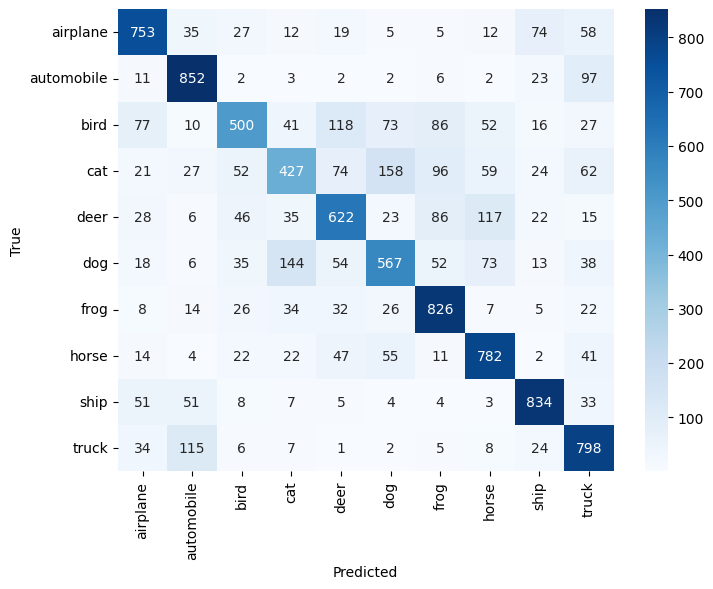

              precision    recall  f1-score   support

    airplane       0.74      0.75      0.75      1000
  automobile       0.76      0.85      0.80      1000
        bird       0.69      0.50      0.58      1000
         cat       0.58      0.43      0.49      1000
        deer       0.64      0.62      0.63      1000
         dog       0.62      0.57      0.59      1000
        frog       0.70      0.83      0.76      1000
       horse       0.70      0.78      0.74      1000
        ship       0.80      0.83      0.82      1000
       truck       0.67      0.80      0.73      1000

    accuracy                           0.70     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.69      0.70      0.69     10000



In [5]:
# --- Step 12: Confusion Matrix for Student ---
y_pred = distiller.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.flatten()
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# --- Step 13: Save Models (Optional) ---
teacher.save("/kaggle/working/cifar_teacher.h5")
student.save("/kaggle/working/cifar_student.h5")